In [193]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import datetime as dt
import matplotlib.pyplot as plt
plt.style.use("seaborn-v0_8")
%matplotlib inline

import yfinance as yf
yf.pdr_override() # this has to be here in order for yahoo finance to work

In [194]:
ticker_symbols = ['SP', 'DIS', 'TSLA', 'NFLX']
end = dt.datetime.now()
start = end - dt.timedelta(days=365*10)

data = pdr.get_data_yahoo(ticker_symbols, start=start, end=end)['Adj Close']

data.tail()

[*********************100%***********************]  4 of 4 completed


,DIS,NFLX,SP,TSLA
Date,,,,
2024-02-02 00:00:00-05:00,97.129997,564.640015,51.860001,187.910004
2024-02-05 00:00:00-05:00,96.650002,562.059998,51.810001,181.059998
2024-02-06 00:00:00-05:00,99.290001,555.880005,52.020000,185.100006
2024-02-07 00:00:00-05:00,99.139999,559.299988,51.500000,187.580002
2024-02-08 00:00:00-05:00,111.780098,557.900024,51.290001,189.404999


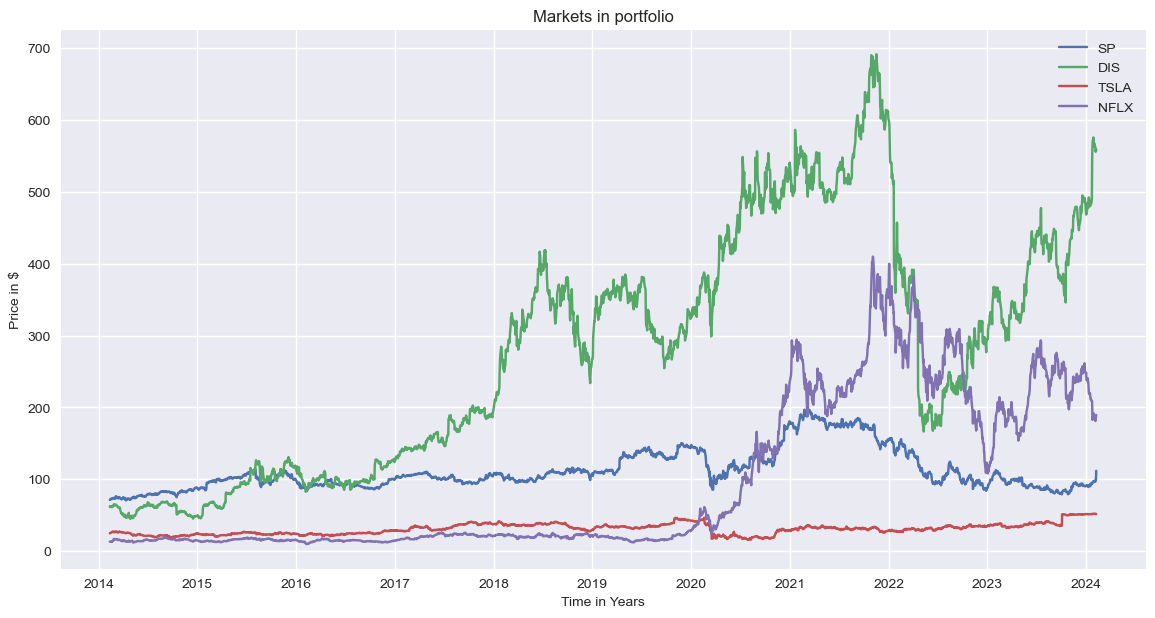

In [195]:
plt.figure(figsize=(14,7))
plt.plot(data)
plt.legend(ticker_symbols, loc='best')
plt.title('Markets in portfolio')
plt.xlabel('Time in Years')
plt.ylabel('Price in $')
plt.show()

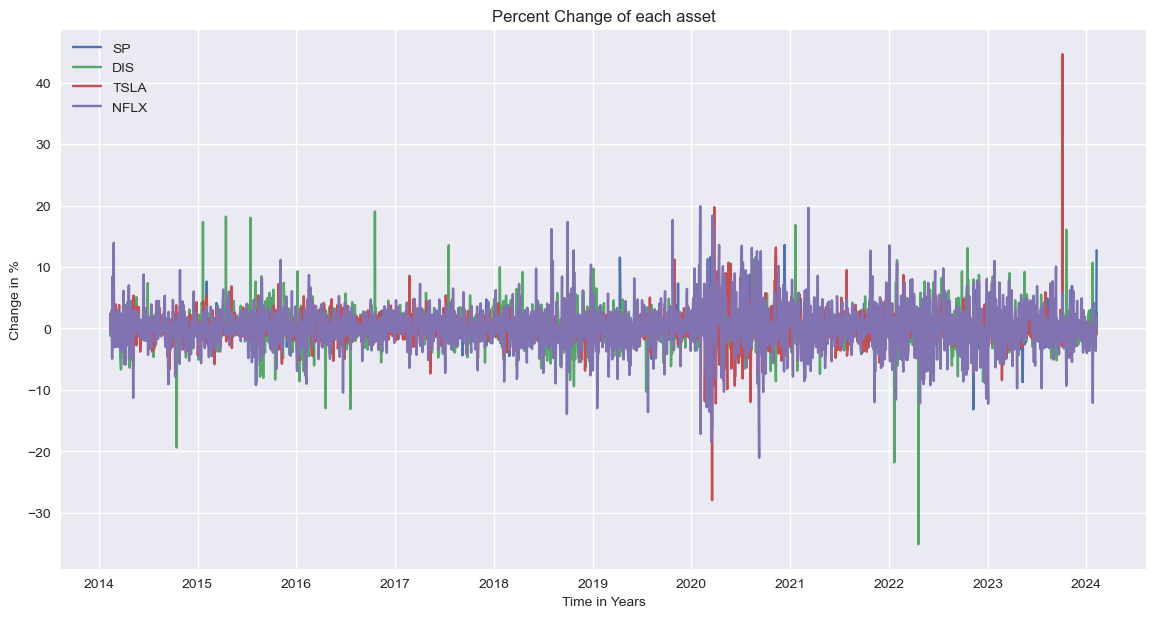

In [196]:
returns = data.pct_change()

plt.figure(figsize=(14,7))
plt.plot(returns*100)
plt.legend(ticker_symbols, loc='best')
plt.title('Percent Change of each asset')
plt.xlabel('Time in Years')
plt.ylabel('Change in %')
plt.show()

[*********************100%***********************]  1 of 1 completed


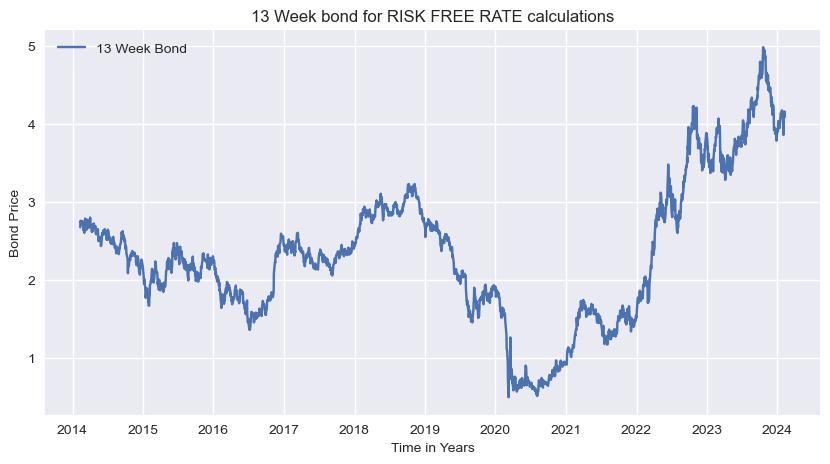

In [197]:
bond = pdr.get_data_yahoo('^TNX', start=start, end=end)['Adj Close']

rate = bond.iloc[-1]

plt.figure(figsize=(10,5))
plt.plot(bond_13_week)
plt.legend(['13 Week Bond'], loc='best')
plt.title('13 Week bond for RISK FREE RATE calculations')
plt.xlabel('Time in Years')
plt.ylabel('Bond Price')
plt.show()

In [198]:
# Define function to calculate returns, volatility
def portfolio_annualized_performance(weights, mean_returns, cov_matrix):
    # Given the avg returns, weights of equities calc. the portfolio return
    returns = np.sum(mean_returns*weights ) *252
    # Standard deviation of portfolio (using dot product against covariance, weights)
    # 252 trading days
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [199]:
def generate_random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    # Initialize array of shape 3 x N to store our results, 
    # where N is the number of portfolios we're going to simulate
    results = np.zeros((3,num_portfolios))
    # Array to store the weights of each equity
    weight_array = []
    for i in range(num_portfolios):
        # Randomly assign floats to our 4 equities
        weights = np.random.random(4)
        # Convert the randomized floats to percentages (summing to 100)
        weights /= np.sum(weights)
        # Add to our portfolio weight array
        weight_array.append(weights)
        # Pull the standard deviation, returns from our function above using 
        # the weights, mean returns generated in this function
        portfolio_std_dev, portfolio_return = portfolio_annualized_performance(weights, mean_returns, cov_matrix)
        # Store output
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        # Sharpe ratio
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weight_array

In [200]:
def display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate):

    # pull results, weights from random portfolios
    results, weights = generate_random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)

    # pull the max portfolio Sharpe ratio (3rd element in results array from 
    # generate_random_portfolios function)
    max_sharpe_idx = np.argmax(results[2])

    # pull the associated standard deviation, annualized return w/ the max Sharpe ratio
    stdev_portfolio, returns_portfolio = results[0,max_sharpe_idx], results[1,max_sharpe_idx]

    # pull the allocation associated with max Sharpe ratio
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=data.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T

    print("-"*100)
    print("Portfolio at maximum Sharpe Ratio\n")
    print("--Returns, volatility--\n")
    print("Annualized Return:", round(returns_portfolio,2))
    print("Annualized Volatility:", round(stdev_portfolio,2))

    print("\n")
    print("--Allocation at max Sharpe ratio--\n")
    print(max_sharpe_allocation)
    print("-"*100)

    plt.figure(figsize=(16, 9))
    # x = volatility, y = annualized return, color mapping = sharpe ratio
    plt.scatter(results[0,:],results[1,:],c=results[2,:], cmap='magma', marker='o', s=10, alpha=.9)
    plt.colorbar()
    # Mark the portfolio w/ max Sharpe ratio
    plt.scatter(stdev_portfolio, returns_portfolio, marker='x',color='r',s=150, label='Max Sharpe ratio')
    plt.title('Simulated portfolios illustrating efficient frontier')
    plt.xlabel('annualized volatility -> RISK')
    plt.ylabel('annualized returns')
    plt.legend(labelspacing=1.2)

----------------------------------------------------------------------------------------------------
Portfolio at maximum Sharpe Ratio

--Returns, volatility--

Annualized Return: 0.34
Annualized Volatility: 0.37


--Allocation at max Sharpe ratio--

             DIS   NFLX     SP   TSLA
allocation  0.04  42.14  14.65  43.16
----------------------------------------------------------------------------------------------------


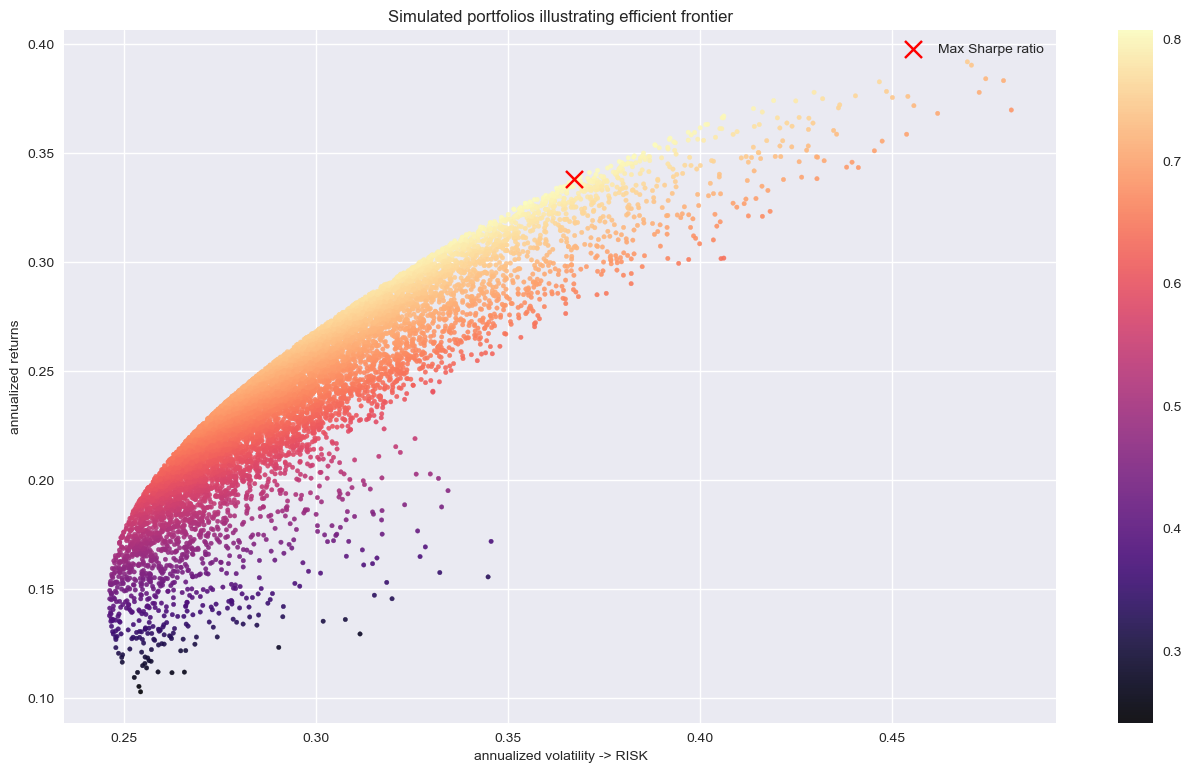

In [201]:
returns = data.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 10_000

# Risk free rate (used for Sharpe ratio below)
# anchored on treasury bond rates, 1 year bond rates, was(0.018)
risk_free_rate = rate/100

display_simulated_portfolios(mean_returns, cov_matrix, num_portfolios, risk_free_rate)